In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic #holistic model
mp_drawing = mp.solutions.drawing_utils # drawing utilities

In [3]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [4]:
def draw_styled_landmark(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), #dot color
                mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) # outline Color
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
     
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False # Image is no longer writeable
    results = model.process(image) #make prediction
    image.flags.writeable = True # image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [6]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened:
        ret, frame = cap.read()
        
        #make predictions
        image, results = mediapipe_detection(frame, holistic)
        
        draw_styled_landmark(image, results) # applying or draw landmark visual to the current image
        
        cv2.imshow("OpenCV Feed",image)
        if cv2.waitKey(10) & 0XFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [7]:
results

mediapipe.python.solution_base.SolutionOutputs

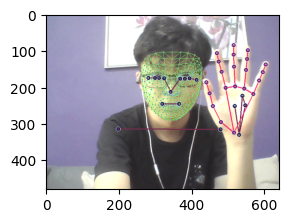

In [8]:
plt.figure(figsize=(3,3))
draw_styled_landmark(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

<h3> 3. Extract Keypoint Values </h3>


In [9]:
results.pose_landmarks.landmark[:2]

[x: 0.5351107
 y: 0.44387358
 z: -1.1539947
 visibility: 0.9999575,
 x: 0.57563543
 y: 0.37030235
 z: -1.1224064
 visibility: 0.999893]

In [10]:
def extract_keypoints(results):
    # if didnt detect any face create np zeros 33*4 , 33 because pose landmark is 33 and times 4 because it has 4 variable, X, Y, Z and Visibility the other dont have Visibility
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # if didnt detect any face create np zeros 468*3 , 468 because face landmark is 21
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    # if didnt detect any (left/right) hand create np zeros 21*3 , 21 because hands landmark is 21
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face, lh, rh])


In [11]:
result_test = extract_keypoints(results)[:10]

In [12]:
result_test

array([ 0.53511071,  0.44387358, -1.15399468,  0.9999575 ,  0.57563543,
        0.37030235, -1.12240636,  0.99989301,  0.5966984 ,  0.36913171])

In [13]:
np.save('0', result_test)

In [14]:
np.load('0.npy')

array([ 0.53511071,  0.44387358, -1.15399468,  0.9999575 ,  0.57563543,
        0.37030235, -1.12240636,  0.99989301,  0.5966984 ,  0.36913171])

<h3> 4. Setup Folder for Collection</h3>

In [3]:
#path for exported data
DATA_PATH = os.path.join('MP_Data')
#action to detect
actions = np.array(['hello', 'thanks','iloveyou','f##kyou','seeyoulater', 'yes','no'])
# actions = np.array(['hello', 'thanks','iloveyou'])
# 30 video worth of data
no_sequences = 30
# video are going to be 30 frames in length
sequence_length = 30
#folder start
# start_folder = 30


In [16]:
# Hello
# 0
# 1
# 2
# 29
# thanks
#i love you
#f##kyou
# friend
# help

In [3]:
for action in actions:
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

<h3>5. Collect Keypoint Values for Training</h3>

In [4]:
actions = np.array(['hello', 'good','iloveyou'])


In [19]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    #NEW loop
    #loop through actions
    for action in actions:
        #loop throug sequence aka video
        for sequence in range(start_folder, start_folder+no_sequences):
            #loop through video length 
            for frame_num in range(sequence_length):
                
                ret, frame = cap.read()
                
                #make predictions
                image, results = mediapipe_detection(frame, holistic)
                
                draw_styled_landmark(image, results) # applying or draw landmark visual to the current image
                
                # NEW apply collection logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1300)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                #NEW export keypoints
                keyponts = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path,keyponts)
                  
                cv2.imshow("OpenCV Feed",image)
                
                if cv2.waitKey(10) & 0XFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()
cap.release()
cv2.destroyAllWindows()

FileNotFoundError: [Errno 2] No such file or directory: 'MP_Data\\hello\\30\\0.npy'

<h3> preprocess Data and create Label and features </h3>

In [20]:
cap.release()
cv2.destroyAllWindows()

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [6]:
label_map = {label:num for num, label in enumerate(actions)}

In [7]:
label_map

{'hello': 0, 'good': 1, 'iloveyou': 2}

In [8]:
sequences,labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH,action,str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [9]:
#180 video, 30 frames, 1662 different keypoint
np.array(sequences).shape

(90, 30, 1662)

In [10]:
np.array(labels).shape

(90,)

In [11]:
X = np.array(sequences)
X.shape

(90, 30, 1662)

In [12]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp,random_state=0)


In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# X_train.shape, X_temp.shape, X_test.shape, y_train.shape, y_temp.shape, y_test.shape

((72, 30, 1662), (9, 30, 1662), (72, 3), (9, 3))

In [15]:
# X_val.shape

In [16]:
y_test

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])

<h3> 7. Build and Train LSTM Neural Network</h3>

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import TensorBoard

In [18]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [19]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
#False because next layer is Dense layer
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


In [20]:
actions.shape[0]

3

In [21]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='acc')

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# checkpoint_path =  ""
#save model best epochs
model_checkpoint_callbacks = ModelCheckpoint(
    filepath = "tmp/checkpoints/model-{epoch:02d}-{val_categorical_accuracy:.2f}.h5",
    save_best_only = True,
    monitor = 'val_categorical_accuracy',
    mode = 'max',
    verbose=0
)

early_stop = EarlyStopping(
    monitor = 'val_categorical_accuracy',
    patience = 700,
    mode= 'max',
    verbose = 0,
    restore_best_weights=True
)

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=100, 
          callbacks=[
              tb_callback, 
              ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'), 
              ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
              ])

Epoch 1/100
3/3 [==============================] - 7s 381ms/step - loss: 124.0986 - categorical_accuracy: 0.3472 - val_loss: 179.5782 - val_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 99ms/step - loss: 115.0548 - categorical_accuracy: 0.2778 - val_loss: 140.1338 - val_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 101ms/step - loss: 72.9092 - categorical_accuracy: 0.3056 - val_loss: 95.7051 - val_categorical_accuracy: 0.4444 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 0s 100ms/step - loss: 130.5417 - categorical_accuracy: 0.2917 - val_loss: 83.6952 - val_categorical_accuracy: 0.4444 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 0s 94ms/step - loss: 98.8220 - categorical_accuracy: 0.3472 - val_loss: 115.5793 - val_categorical_accuracy: 0.2222 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 0s 100ms/step - loss: 126.1705 - categorical_

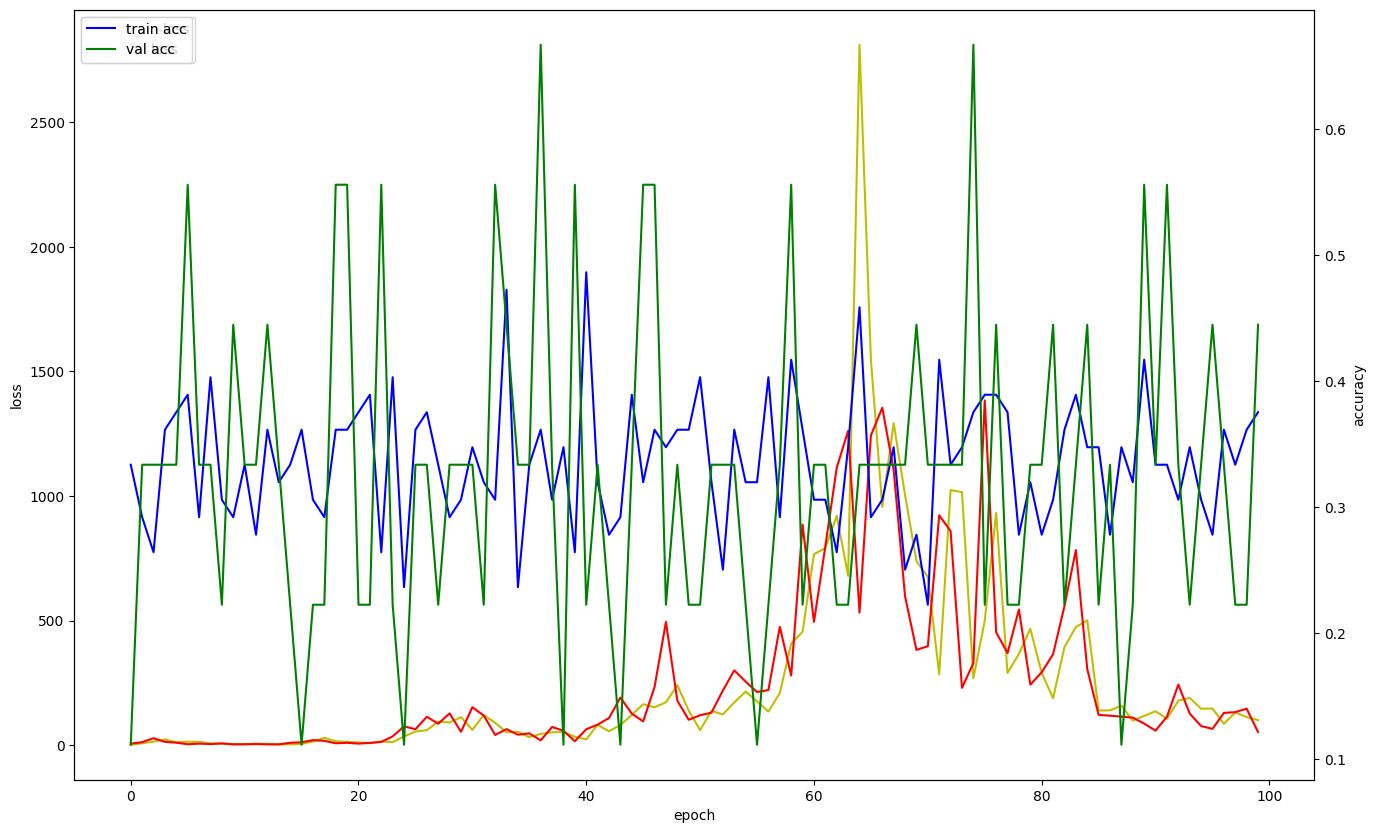

In [24]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 596675 

In [26]:
# from tensorflow.keras.models import load_model
# best_model = load_model("tmp/checkpoints/model-04-0.99.h5")
res = model.predict(X_test)
actions[np.argmax(res[1])]

1/1 [==============================] - 1s 527ms/step


'good'

In [27]:
actions[np.argmax(y_test[1])]

'hello'

<h3> 9. Save model</h3>

In [28]:
model.save("action.h5")
del model

In [29]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
#False because next layer is Dense layer
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='categorical_accuracy')

In [30]:
model.load_weights("action.h5")

<h3> 10. Evaluation using Confusion matrix and accuracy</h3>

In [31]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [32]:
yhat = model.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

1/1 [==============================] - 1s 555ms/step


In [33]:
multilabel_confusion_matrix(y_true,yhat)

array([[[6, 0],
        [3, 0]],

       [[4, 2],
        [2, 1]],

       [[2, 4],
        [1, 2]]], dtype=int64)

In [34]:
accuracy_score(y_true, yhat)

0.3333333333333333

<h3> 11. Test in real time</h3>

In [35]:
colors = [(245,117,16), (102,0,204), (117,245,16), (16,117,245), (255,153,51), (204,0,204), (204,5,10)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,50+num*20), (int(prob*50), 70+num*20), colors[num],-1)
        # cv2.putText(output_frame, action[num], (0, 85+num*40),  cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 2 , cv2.LINE_AA)
        cv2.putText(output_frame, actions[num], (0, 65+num*20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
        
    return output_frame
    

In [36]:
# 1. new detection variable
sequence = []
sentence = []
predictions = []
threshold = 0.7

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened:
        ret, frame = cap.read()
        
        #make predictions
        image, results = mediapipe_detection(frame, holistic)
        
        draw_styled_landmark(image, results) # applying or draw landmark visual to the current image
        
        #2. prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            # print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
        
        #3. viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)]!= sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])
        
            if len(sentence) > 3:
                sentence = sentence[-3:]
            
            #viz probabilities
            image = prob_viz(res, actions, image, colors)
        
        cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
        cv2.putText(image, " ".join(sentence), (3,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1 , (255,255,255), 2,
                    cv2.LINE_AA)
        
        cv2.imshow("OpenCV Feed",image)
        if cv2.waitKey(10) & 0XFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
cap.release()
cv2.destroyAllWindows()

NameError: name 'mp_holistic' is not defined

In [ ]:
cap.release()
cv2.destroyAllWindows()